### Notebook to genereate binned cross sections from TC output

Assumes output is in a single netcdf file on pressure levels.

James Ruppert  
jruppert@ou.edu  
4/23/22

In [24]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys

#### Time selection

In [2]:
t0 = 48
t1 = t0+24

#### Directories

In [20]:
# main = "/Users/jamesruppert/code/tc_output/"
main = "/Users/jruppert/code/tc_output/"
storm = !ls $main
# print(memb)

istorm=storm[0]
memb = !ls $main/$istorm
imemb=memb[0]

datdir = main+istorm+'/'+imemb+'/ncrf/'

#### Read variables

In [21]:
# Fill contour variable
varfil = Dataset(datdir+'dbz.nc') # this opens the netcdf file
binvar_f_in = varfil.variables['dbz'][t0:t1,:,:,:]
units_var1 = 'dBZ'

varfil = Dataset(datdir+'strat.nc') # this opens the netcdf file
strat_in = varfil.variables['strat'][t0:t1,:,:,:]

# varfil = Dataset(datdir+'RTHRATLW.nc') # this opens the netcdf file
# binvar_f_in = varfil.variables['RTHRATLW'][t0:t1,:,:,:] * 3600.*24 # K/s --> K/d
units_var1 = 'K/d'

# varfil = Dataset(datdir+'W.nc') # this opens the netcdf file
# binvar_f_in = varfil.variables['W'][t0:t1,:,:,:]
# units_var1 = 'm/s'

bv_shape = np.shape(binvar_f_in)
print("Binvar shape: ",bv_shape)
nt = bv_shape[0]
nz = bv_shape[1]

Binvar shape:  (24, 10, 740, 1400)


In [5]:
# Vertical coordinate
pres = varfil.variables['pres'][:] # Pa
print("Vertical shape: ",np.shape(pres))

Vertical shape:  (10,)


In [6]:
# Line contour variable
varfil2 = Dataset(datdir+'W.nc') # this opens the netcdf file
binvar_c_in = varfil2.variables['W'][t0:t1,:,:,:] # m/s
units_var2='m/s'

In [7]:
# Indexing variable
binfil = Dataset(datdir+'pw.nc') # this opens the netcdf file
ivar = binfil.variables['PW'][t0:t1,:,:,:]
print("PW shape: ",np.shape(ivar))

PW shape:  (24, 1, 740, 1400)


#### Create PW Bins

In [8]:
fmin=35 # mm
fmax=70
step=1
bins = np.arange(fmin,fmax,step)
nbins = np.size(bins)

#### Bin the target variable

In [50]:
binvar_f = np.zeros((nbins,nt,nz)) # nbins, nt, nz
binvar_c = np.zeros((nbins,nt,nz))
binvar_strat = np.zeros((nbins,nt,3))

# for ibin in range(nbins):
for itim in range(nt):
    for ibin in range(nbins):
        indices = ((ivar[itim,0,:,:] >= bins[ibin]-0.5*step) & (ivar[itim,0,:,:] < bins[ibin]+0.5*step)).nonzero()
        tmp_f = binvar_f_in[itim,:,indices[0],indices[1]]
        binvar_f[ibin,itim,:] = np.mean(tmp_f,axis=0,dtype=np.float64)
        tmp_c = binvar_c_in[itim,:,indices[0],indices[1]]
        binvar_c[ibin,itim,:] = np.mean(tmp_c,axis=0,dtype=np.float64)
        tmp_strat = strat_in[itim,:,indices[0],indices[1]]
        for istrat in range(3):
            iindex = ((tmp_strat == (istrat+1))).nonzero()
            binvar_strat[ibin,itim,0] = np.shape(iindex)[1]

#### Time-average

In [10]:
binvar_f_mn = np.mean(binvar_f,axis=1)
binvar_c_mn = np.mean(binvar_c,axis=1)

---
### Plotting routines

In [11]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

NameError: name 'strat' is not defined

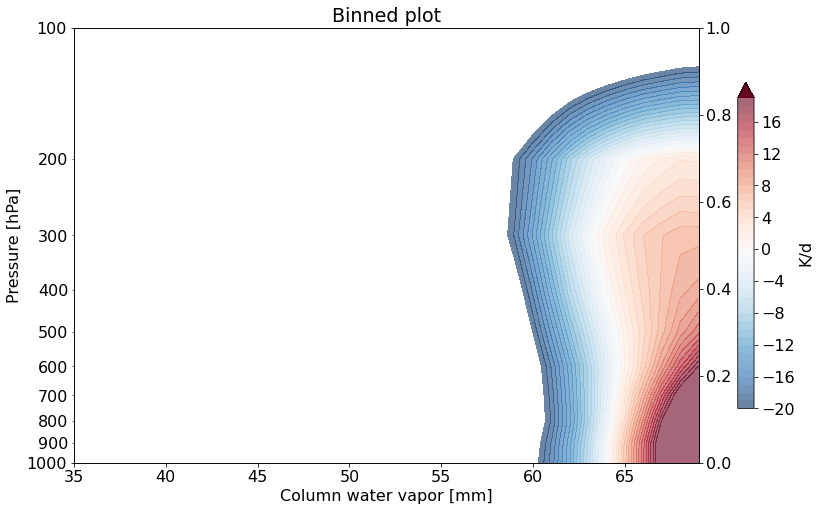

In [18]:
# create figure
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)

ax.set_title('Binned plot')
ax.set_ylabel('Pressure [hPa]')
ax.set_xlabel('Column water vapor [mm]')

# fill contour
# clevs = np.arange(-2, 2, 0.2)
clevs = np.arange(-20, 20, 1)
pltvar=binvar_f_mn
im = ax.contourf(bins, pres, np.transpose(pltvar), clevs, cmap='RdBu_r', alpha=0.6, \
                 extend='max', zorder=2)
cbar = plt.colorbar(im, ax=ax, shrink=0.75)
cbar.ax.set_ylabel(units_var1)
ax.invert_yaxis()
ax.set_yscale('log')
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())

ax2=ax.twinx()
im = ax.plot(bins, strat)

# line contours of geopotential height (in black)
# clevs = np.arange(800, 1000, 10) # may need to adapt these for the pressure level
# im = plt.contour(lon, lat, geoz, clevs_phi, colors='black', projection=cartopy.crs.PlateCarree(), zorder=2)
# ax.clabel(im, im.levels, inline=True, fontsize=13)

plt.show()